In [1]:
#En este bloque se importa todo lo necesario para la ejecución de operaciones relacionadas al proyecto.

#Se utiliza:
#OpenCV 2
#Funcionalidades del Sistema Operativo (OS)
#Funciones y parametros especificos del sistema (SYS)
#Numpy
#Pandas
#Matplotlib
#ipywidgets
#scikit-learn

#Cada celda tendrá un %%time, el cual nos ayudara a ver el tiempo de ejecución de esta, y asi poder predecir a futuro que tareas
#requieren más recursos/son más intensivas.

import os
import sys
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as skl
import scipy as sp

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score

print('OpenCV: ', cv.__version__)
print('NumPy: ', np.__version__)
print('Pandas: ', pd.__version__)
print('SKlearn: ', skl.__version__)
print('Matplotlib: ', mpl.__version__)
print('SciPy: ', sp.__version__)
print('Python: ', sys.version)

%matplotlib inline

OpenCV:  4.1.0
NumPy:  1.16.4
Pandas:  0.24.2
SKlearn:  0.21.2
Matplotlib:  3.1.0
SciPy:  1.2.1
Python:  3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [2]:
#En este bloque definimos una función que nos permite observar el progreso iterativo de ciclos en jupyter, usando python
#Fuente: https://github.com/kuk/log-progress

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [16]:
#En este bloque se extrae la información del dataset, el cual no es un dataset común de datos en texto, sino un grupo de
#imagenes organizado por carpetas, y cada carpeta está nombrada por su respectiva clase.

#Luego de extraer la información se manipula con filtros, especificamente: blur gaussiano, segmentación de otsu, y
#redimensionamiento. Luego se procede a dividir lo extraido en dos grupos, uno de entrenamiento con el 80%, y otro de prueba
#con el 20%.

#Por último, debido a limitaciones de capacidad de procesamiento, el dataset original se redujo a 100 imagenes por clase,
#para poder realizar las pruebas en un tiempo sensible, y hacer cambios de manera rápida, por lo cual la precisión al examinar
#los datos es generalmente baja.

#Fuente del dataset: https://github.com/cs-chan/ArtGAN/tree/master/WikiArt%20Dataset
#79306 imágenes distribuidas en 27 clases, la de menor cantidad tiene 98, y la de mayor cantidad tiene 13060

path_classes = 'artsource_dataset_full/'
classes_names = os.listdir(path_classes)
print(classes_names)
dic_imgs ={}


for i, name_class in enumerate(classes_names):
    dic_imgs[classes_names[i]] = np.array(os.listdir(path_classes + classes_names[i]))

X =[]
y =[]

ker_size = (15,) * 2
resize = 200

for i, classes in log_progress(enumerate(['Abstract_Expressionism',
                             'Action_painting',
                             'Analytical_Cubism',
                             'Art_Nouveau_Modern',
                             'Baroque',
                             'Color_Field_Painting',
                             'Contemporary_Realism',
                             'Cubism',
                             'Early_Renaissance',
                             'Expressionism',
                             'Fauvism',
                             'High_Renaissance',
                             'Impressionism',
                             'Mannerism_Late_Renaissance',
                             'Minimalism',
                             'Naive_Art_Primitivism',
                             'New_Realism',
                             'Northern_Renaissance',
                             'Pointillism',
                             'Pop_Art',
                             'Post_Impressionism',
                             'Realism',
                             'Rococo',
                             'Romanticism',
                             'Symbolism',
                             'Synthetic_Cubism',
                             'Ukiyo_e']), every = 1):
    print(classes)
    for im_name in log_progress(dic_imgs[classes], every = 1):
        path_image = path_classes+classes+'/'+im_name
        
        stream = open(path_image, "rb") #linea para opencv en windows, borrar en ubuntu
        bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
        img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
        cvimg = cv.imdecode(img_array, cv.IMREAD_UNCHANGED) #linea para opencv en windows, borrar en ubuntu
        
        #cvimg = cv.cvtColor(cv.imread(path_image, 1), cv.COLOR_BGR2RGB) en ubuntu
        cvblur = cv.GaussianBlur(cvimg, ker_size, 0)

        if(cvimg.shape[1] > 800 or cvimg.shape[0] > 800):
            resize_x = int(cvimg.shape[1]/10)
            resize_y = int(cvimg.shape[0]/10)
            resize_factor = (resize, resize) #(resize_x, resize_y)
            cvresize = np.uint8(cv.resize(cvblur, resize_factor)*1.)
            flatt_img = cvresize.reshape(resize*resize*3) #(resize_x*resize_y*3)
        else:
            cvresize = np.uint8(cv.resize(cvblur, (resize,resize))*1.)
            flatt_img = cvresize.reshape(resize*resize*3)
            #flatt_img = cvimg.reshape(100*100*3) #(cvimg.shape[1]*cvimg.shape[0]*3)
        #ret,img = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
        X.append(flatt_img)
        y.append(i+1)

X = np.r_[X]        
y = np.r_[y]

from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
print(y_test)

['Abstract_Expressionism', 'Action_painting', 'Analytical_Cubism', 'Art_Nouveau_Modern', 'Baroque', 'Color_Field_Painting', 'Contemporary_Realism', 'Cubism', 'Early_Renaissance', 'Expressionism', 'Fauvism', 'High_Renaissance', 'Impressionism', 'Mannerism_Late_Renaissance', 'Minimalism', 'Naive_Art_Primitivism', 'New_Realism', 'Northern_Renaissance', 'Pointillism', 'Pop_Art', 'Post_Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Symbolism', 'Synthetic_Cubism', 'Ukiyo_e']


MemoryError: 

In [37]:
#test
for i, classes in log_progress(enumerate(['Abstract_Expressionism',
                             'Action_painting',
                             'Analytical_Cubism',
                             'Art_Nouveau_Modern',
                             'Baroque',
                             'Color_Field_Painting',
                             'Contemporary_Realism',
                             'Cubism',
                             'Early_Renaissance',
                             'Expressionism',
                             'Fauvism',
                             'High_Renaissance',
                             'Impressionism',
                             'Mannerism_Late_Renaissance',
                             'Minimalism',
                             'Naive_Art_Primitivism',
                             'New_Realism',
                             'Northern_Renaissance',
                             'Pointillism',
                             'Pop_Art',
                             'Post_Impressionism',
                             'Realism',
                             'Rococo',
                             'Romanticism',
                             'Symbolism',
                             'Synthetic_Cubism',
                             'Ukiyo_e']), every = 1):
    print(classes)
    for j, im_name in log_progress(enumerate(dic_imgs[classes]), every = 1):
        if(j < 200):
            path_image = path_classes+classes+'/'+im_name
        
            stream = open(path_image, "rb") #linea para opencv en windows, borrar en ubuntu
            bytes = bytearray(stream.read()) #linea para opencv en windows, borrar en ubuntu
            img_array = np.asarray(bytes, dtype=np.uint8) #linea para opencv en windows, borrar en ubuntu
            cvimg = cv.imdecode(img_array, cv.IMREAD_UNCHANGED) #linea para opencv en windows, borrar en ubuntu
        
            #cvimg = cv.cvtColor(cv.imread(path_image, 1), cv.COLOR_BGR2RGB) en ubuntu
            cvblur = cv.GaussianBlur(cvimg, ker_size, 0)

            if(cvimg.shape[1] > 800 or cvimg.shape[0] > 800):
                resize_x = int(cvimg.shape[1]/10)
                resize_y = int(cvimg.shape[0]/10)
                resize_factor = (resize, resize) #(resize_x, resize_y)
                cvresize = np.uint8(cv.resize(cvblur, resize_factor)*1.)
                flatt_img = cvresize.reshape(resize*resize*3) #(resize_x*resize_y*3)
            else:
                cvresize = np.uint8(cv.resize(cvblur, (resize,resize))*1.)
                flatt_img = cvresize.reshape(resize*resize*3)
                #flatt_img = cvimg.reshape(100*100*3) #(cvimg.shape[1]*cvimg.shape[0]*3)
            #ret,img = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
            X.append(flatt_img)
            y.append(i+1)

X = np.r_[X]        
y = np.r_[y]

Abstract_Expressionism


Action_painting


Analytical_Cubism


Art_Nouveau_Modern


Baroque


Color_Field_Painting


Contemporary_Realism


Cubism


Early_Renaissance


Expressionism


Fauvism


High_Renaissance


Impressionism


Mannerism_Late_Renaissance


Minimalism


Naive_Art_Primitivism


New_Realism


Northern_Renaissance


Pointillism


Pop_Art


Post_Impressionism


Realism


Rococo


Romanticism


Symbolism


Synthetic_Cubism


Ukiyo_e


MemoryError: 

(2698, 120000)
0.10925925925925926


D:\anaconda\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


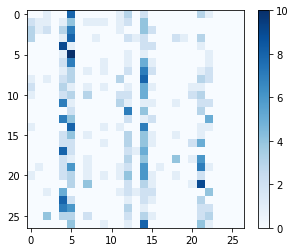

In [15]:
#En este bloque se importa el clasificador KNN, y se prosigue a realizar la clasificación con los dos grupos anteriores de
#entrenamiento y prueba, con los 10 vecinos más cercanos. Últimamente, para visualizar los resultados y su precisión, se imprime
#la matriz de confusión.

neigh = KNeighborsClassifier(n_neighbors=19) #19 vecinos es lo mas óptimo
print(X.shape)
neigh.fit(X_train, y_train)
print(neigh.score(X_test, y_test))


from sklearn.metrics import confusion_matrix
predicciones_train = neigh.predict(X_train)
predicciones_test  = neigh.predict(X_test)

cm_train = confusion_matrix(y_train, predicciones_train)
cm_test = confusion_matrix(y_test, predicciones_test)

plt.figure(figsize=(17,4))
plt.subplot(132),plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.subplot(132),plt.colorbar();

In [16]:
#En este bloque, por curiosidad de saber que número de vecinos da mejores resultados al aplicar KNN, se hizo una prueba con
#su cantidad variando desde 1 hasta 20.

neighbors = np.linspace(1,30,30)
accuracy = []
for i in log_progress(range(30), every = 1):
    neigh = KNeighborsClassifier(n_neighbors = i+1)
    neigh.fit(X_train, y_train)
    accuracy.append(neigh.score(X_test, y_test))
    print(accuracy[i])
plt.plot(neighbors, accuracy)

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(accuracy[i])? (<ipython-input-16-886b84f259f7>, line 10)

In [20]:
p = Pipeline((("nca", skl.neighbors.NeighborhoodComponentsAnalysis()), ("classifier", KNeighborsClassifier(n_neighbors=3))))
#s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
#print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))
nca = skl.neighbors.NeighborhoodComponentsAnalysis(random_state = 42)
nca.fit(X_train, y_train) 
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train) 
print(knn.score(X_test, y_test)) 
knn.fit(nca.transform(X_train), y_train) 
print(knn.score(nca.transform(X_test), y_test))

MemoryError: 

In [19]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", RandomForestClassifier(n_estimators = 100)) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

accuracy 0.181 (+/- 0.01678)


accuracy 0.177 (+/- 0.01421)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


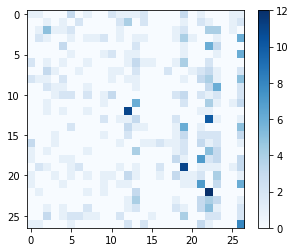

In [18]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", GaussianNB()) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [ ]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'poly', gamma = 'scale')) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

D:\anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'rbf', gamma = 'scale')) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [ ]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'sigmoid', gamma = 'scale')) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

In [ ]:
p = Pipeline((("pca", PCA(n_components=100)), ("classifier", SVC(kernel = 'linear', gamma = 'scale')) ))
s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
print("accuracy %.3f (+/- %.5f)"%(np.mean(s), np.std(s)))

1000 2000 3000 4000 5000 6000 7000 8000 9000

Text(0.5,1,u'GaussianNB')

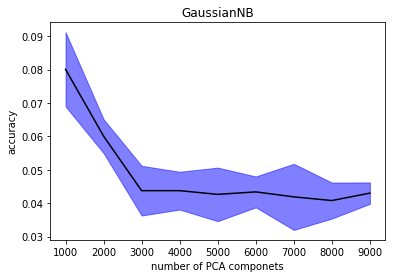

In [8]:
n_components = range(100,1000,100)
means, stds = [], []

for n in n_components:
    print n,
    p = Pipeline((("pca", PCA(n_components=n)), ("classifier", RandomForestClassifier()) ))
    s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
    means.append(np.mean(s))
    stds.append(np.std(s))
means = np.r_[means]
stds  = np.r_[stds]

plt.plot(n_components, means, color="black")
plt.fill_between(n_components, means-stds, means+stds, color="blue", alpha=.5)
plt.xlabel("number of PCA componets")
plt.ylabel("accuracy")
plt.title("GaussianNB")

In [ ]:
n_components = range(100,1000,100)
means, stds = [], []

for n in n_components:
    print n,
    p = Pipeline((("pca", PCA(n_components=n)), ("classifier", GaussianNB()) ))
    s = cross_val_score(p, X, y, cv=KFold(5, shuffle=True), scoring=make_scorer(accuracy_score))
    means.append(np.mean(s))
    stds.append(np.std(s))
means = np.r_[means]
stds  = np.r_[stds]

plt.plot(n_components, means, color="black")
plt.fill_between(n_components, means-stds, means+stds, color="blue", alpha=.5)
plt.xlabel("number of PCA componets")
plt.ylabel("accuracy")
plt.title("GaussianNB")

dimensiones train (2158, 120000) (2158,)
dimsensions test  (540, 120000) (540,)
acierto en train 0.18443002780352177
acierto en test 0.1388888888888889
verifica número de imágenes en total por fila
[15 20 21 22 24 17 31 20 20 20 22 16 15 20 15 22 29 23 17 16 20 18 21 22
 16 22 16]


D:\anaconda\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


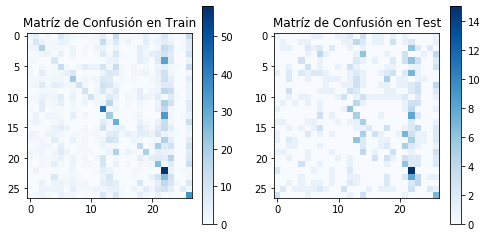

In [9]:
test_size = 0.2

d_train, d_test, c_train, c_test = train_test_split(X,y,test_size=test_size)

print("dimensiones train", d_train.shape, c_train.shape)
print("dimsensions test ", d_test.shape, c_test.shape)

g = GaussianNB()
g.fit(d_train, c_train)
print("acierto en train", g.score(d_train, c_train))
print("acierto en test", g.score(d_test, c_test))

predicciones_train = g.predict(d_train)
predicciones_test  = g.predict(d_test)

cm_train = confusion_matrix(c_train, predicciones_train)
cm_test = confusion_matrix(c_test, predicciones_test)
#print("matrix de confusión en train\n", cm_train)
#print("matrix de confusión en test\n", cm_test)
print("verifica número de imágenes en total por fila")
print(np.sum(cm_test, axis=1))

plt.figure(figsize=(17,4))
plt.subplot(141), plt.title('Matríz de Confusión en Train'), plt.imshow(cm_train, interpolation="nearest", cmap=plt.cm.Blues);
plt.subplot(141), plt.colorbar();
plt.subplot(142), plt.title('Matríz de Confusión en Test'), plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.subplot(142), plt.colorbar();

In [17]:
test_size = 0.25

d_train, d_test, c_train, c_test = train_test_split(X,y,test_size=test_size)

print("dimensiones train", d_train.shape, c_train.shape)
print("dimsensions test ", d_test.shape, c_test.shape)

g = RandomForestClassifier(n_estimators = 100)
g.fit(d_train, c_train)
print("acierto en train", g.score(d_train, c_train))
print("acierto en test", g.score(d_test, c_test))

predicciones_train = g.predict(d_train)
predicciones_test  = g.predict(d_test)

cm_train = confusion_matrix(c_train, predicciones_train)
cm_test = confusion_matrix(c_test, predicciones_test)
#print("matrix de confusión en train\n", cm_train)
#print("matrix de confusión en test\n", cm_test)
print("verifica número de imágenes en total por fila")
print(np.sum(cm_test, axis=1))

plt.figure(figsize=(17,4))
plt.subplot(141), plt.title('Matríz de Confusión en Train'), plt.imshow(cm_train, interpolation="nearest", cmap=plt.cm.Blues);
plt.subplot(141), plt.colorbar();
plt.subplot(142), plt.title('Matríz de Confusión en Test'), plt.imshow(cm_test, interpolation="nearest", cmap=plt.cm.Blues);
plt.subplot(142), plt.colorbar();

AttributeError: 'list' object has no attribute 'shape'